In [2]:
import math
import os
import numpy as np
import pandas as pd
import torch
import gpytorch
import matplotlib.pyplot as plt
import datetime 
from sklearn.model_selection import train_test_split

Getting data from spy folder

In [3]:
# loading in futures data
import pickle 
import datetime

# open futures.pickle
with open('futures.pickle', 'rb') as handle:
    futures = pickle.load(handle)

name_map = {'H':3, 'M':6, 'U':9, 'Z':12}
future_chain = {}
for es in futures:
    date = str(name_map[es[2]]) + '-' + es[-2:]
    future_chain[date] = futures[es]
    future_chain[date].index = pd.to_datetime(future_chain[date].index)
    

def fwd_price(quote_date, ttm, underlying):
    # find the futures contract that is closest to the ttm

    for es in future_chain.keys():
        if pd.to_datetime(es, format="%m-%y") > quote_date:
            break
        
    # find next 4 contracts and get prices on quote_date
    dates = [quote_date]
    for i in range(4):
        dates.append(pd.to_datetime(es, format="%m-%y") + pd.DateOffset(months=3*i))
        
    fwd_curve = [underlying]
    for date in dates[1:]:
        price = future_chain[date.strftime("%-m-%y")].loc[quote_date]
        fwd_curve.append(price.iloc[0] / 10)

    
    # interpolate to get the price at ttm
    ttm = (ttm - quote_date).days / 365
    ttm_curve = [0]
    for i in range(1, len(dates)):
        ttm_curve.append((dates[i] - quote_date).days / 365)
    
    fwd_curve = np.array(fwd_curve)
    ttm_curve = np.array(ttm_curve)
    fwd_price = np.interp(ttm, ttm_curve, fwd_curve)
    
    return fwd_price
    



In [4]:
# dumas vol surface
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def dumas_surface(df):
    X = df['mny']
    T = df['T']
    
    df['X^2'] = X**2
    df['T^2'] = T**2
    df['XT'] = X*T
    
    features = df[['mny', 'X^2', 'T', 'T^2', 'XT']]
    target = df['iv']
    
    model = LinearRegression()
    model.fit(features, target)

    return model

In [5]:
daily_chains = {}
files = os.listdir('../option_data/spy_data')[1:]
files.sort(key=lambda x: x[-14:-4])

for file in files:
    if file[-4:] == '.csv':
                
        df = pd.read_csv('../option_data/spy_data/' + file)        
        
        # moving to datetime and making features
        df['quote_datetime'] = pd.to_datetime(df['quote_datetime'])
        df['expiration'] = pd.to_datetime(df['expiration'])
        df['quote_date'] = df['quote_datetime'][0].date()
        df['quote_date'] = pd.to_datetime(df['quote_date'])
        
        # getting only 4:00 quotes
        eod = datetime.datetime.combine(df['quote_datetime'][0].date(), datetime.time(16,0, 0))
        df = df.loc[df['quote_datetime'] == eod]
        
        # getting forward price
        df['fwd_price'] = df.apply(lambda x: fwd_price(x['quote_date'], x['expiration'], x['active_underlying_price']), axis=1)
                
        # getting time to expiration and moneyness
        df['T'] = df['expiration'] - df['quote_date']
        df['T'] = df['T'].dt.days
        df['moneyness'] = df['fwd_price'] / df['strike'] 
        
        # converting to ML features
        df['T'] = df['T'].astype(np.float32)
        df['mny'] = df['moneyness'].astype(np.float32)
        df['iv'] = df['implied_volatility'].astype(np.float32)
        
        # filtering for research paper criteria
        df = df.loc[(df['close']!=0) & (df['iv']!=0) & (df['T']>=20) & (df['T']<=365) & (df['mny']>0.7) & (df['mny']<1.3)]
                
        # splitting up into calls/puts
        calls = df.loc[df['option_type']=='C'][['T', 'mny', 'iv']]
        puts = df.loc[df['option_type']=='P'][['T', 'mny', 'iv']]
        opts = {'calls':calls, 'puts':puts}
    
        # assinging to date
        daily_chains[file[-14:-4]] = opts 

In [6]:
# days in dataset:
_ = [print(k) for k in sorted(daily_chains.keys())]

2023-10-02
2023-10-03
2023-10-04
2023-10-05
2023-10-06
2023-10-09
2023-10-10
2023-10-11
2023-10-12
2023-10-13
2023-10-16
2023-10-17
2023-10-18
2023-10-19
2023-10-20
2023-10-23
2023-10-24
2023-10-25
2023-10-26
2023-10-27
2023-10-30
2023-10-31


GP definition

In [7]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

Training code 

In [8]:
def custom_split(df, n_bins, test_size=0.2):
    
    # bin moneyness
    grouped = df.groupby(['T'])
    
    train_dfs = []
    test_dfs = []
    
    for _, group in grouped:
        # if not enough data
        if len(group)//n_bins <= 1/test_size:
            train, test = train_test_split(group, test_size=test_size)
            
        # split into bins
        else:
            group['bins'] = pd.qcut(group['mny'], n_bins, duplicates='drop', labels=False)
            train, test = train_test_split(group, test_size=test_size, stratify=group['bins'])

        train_dfs.append(train)
        test_dfs.append(test)
    
    train_df = pd.concat(train_dfs)
    test_df = pd.concat(test_dfs)
    
    return train_df, test_df
        
    

In [9]:
import warnings
warnings.filterwarnings("ignore", message="is_sparse is deprecated and will be removed in a future version")

gp_models = {}

for day, options in list(daily_chains.items())[:5]:
    
    info = {}
    
    # calls and puts
    c = options['calls']
    p = options['puts']
    
    # feature transformations
    c['mm_T'] = (c['T'] - 20)/(365-20)
    c['mm_mny'] = (c['mny'] - 0.7)/(1.3-0.7)
    c['ln_iv'] = np.log(c['iv'])

    p['mm_T'] = (p['T'] - 20)/(365-20)
    p['mm_mny'] = (p['mny'] - 0.7)/(1.3-0.7)
    p['ln_iv'] = np.log(p['iv'])
    
    # test/train split
    c_train, c_test = custom_split(c, 3, test_size=0.2)
    p_train, p_test = custom_split(p, 3, test_size=0.2)
    info['call_train'] = c_train
    info['call_test'] = c_test
    info['put_train'] = p_train
    info['put_test'] = p_test
    
    # into tensors
    cx_train = torch.tensor(c_train[['mm_T', 'mm_mny']].values)
    cy_train = torch.tensor(c_train[['ln_iv']].values).reshape(len(c_train))
    cx_test = torch.tensor(c_test[['mm_T', 'mm_mny']].values)
    cy_test = torch.tensor(c_test[['ln_iv']].values).reshape(len(c_test))
    
    px_train = torch.tensor(p_train[['mm_T', 'mm_mny']].values)
    py_train = torch.tensor(p_train[['ln_iv']].values).reshape(len(p_train))
    px_test = torch.tensor(p_test[['mm_T', 'mm_mny']].values)
    py_test = torch.tensor(p_test[['ln_iv']].values).reshape(len(p_test))
    
    #break
    # initializing likelihood and model
    c_likelihood = gpytorch.likelihoods.GaussianLikelihood()
    c_model = ExactGPModel(cx_train, cy_train, c_likelihood)  
    
    p_likelihood = gpytorch.likelihoods.GaussianLikelihood()
    p_model = ExactGPModel(px_train, py_train, p_likelihood)  
    
    # finding optimal model parameters
    c_model.train()
    c_likelihood.train()

    p_model.train()
    p_likelihood.train()
    
    # Use the adam optimizer
    c_optimizer = torch.optim.Adam(c_model.parameters(), lr=0.2) 
    p_optimizer = torch.optim.Adam(p_model.parameters(), lr=0.2) 

    # "Loss" for GPs - the marginal log likelihood
    c_mll = gpytorch.mlls.ExactMarginalLogLikelihood(c_likelihood, c_model)
    p_mll = gpytorch.mlls.ExactMarginalLogLikelihood(p_likelihood, p_model)
    c_losses = []
    p_losses = []
    
    training_iter = 100
    print('STARTING CALL GP TRAINING FOR ', day)
    for i in range(training_iter):
        # Zero gradients from previous iteration
        c_optimizer.zero_grad()
        # Output from model
        c_output = c_model(cx_train)
        # Calc loss and backprop gradients
        c_loss = -c_mll(c_output, cy_train)
        c_loss.backward()
        
        c_losses.append(c_loss.item())
        if i % 5 == -1:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, c_loss.item(),
                c_model.covar_module.base_kernel.lengthscale.item(),
                c_model.likelihood.noise.item()
            ))
        c_optimizer.step()
        
    print('STARTING PUT GP TRAINING FOR ', day)
    for i in range(training_iter):
        # Zero gradients from previous iteration
        p_optimizer.zero_grad()
        # Output from model
        p_output = p_model(px_train)
        # Calc loss and backprop gradients
        p_loss = -p_mll(p_output, py_train)
        p_loss.backward()
        
        p_losses.append(p_loss.item())
        if i % 5 == -1:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, p_loss.item(),
                p_model.covar_module.base_kernel.lengthscale.item(),
                p_model.likelihood.noise.item()
            ))
        p_optimizer.step()
    
    info['call_losses'] = c_losses
    info['put_losses'] = p_losses

    # Get into evaluation (predictive posterior) mode
    c_model.eval()
    c_likelihood.eval()
    
    p_model.eval()
    p_likelihood.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        c_preds = c_likelihood(c_model(cx_test))
        p_preds = p_likelihood(p_model(px_test))

    info['call_preds'] = c_preds
    info['put_preds'] = p_preds        

    # rmse
    c_rmse = torch.sqrt(torch.mean(torch.pow(math.e ** c_preds.mean - math.e ** cy_test, 2)))
    p_rmse = torch.sqrt(torch.mean(torch.pow(math.e ** p_preds.mean - math.e ** py_test, 2)))
    info['call_RMSE'] = c_rmse
    info['put_RMSE'] = p_rmse
    
    # saving the model
    torch.save(c_model, 'models/call_GP_'+day+'.pt')
    torch.save(p_model, 'models/put_GP_'+day+'.pt')
    
    # saving likelihood
    info['call_likelihood'] = c_likelihood
    info['put_likelihood'] = p_likelihood
    
    gp_models[day] = info  
        

STARTING CALL GP TRAINING FOR  2023-10-02
STARTING PUT GP TRAINING FOR  2023-10-02
STARTING CALL GP TRAINING FOR  2023-10-03
STARTING PUT GP TRAINING FOR  2023-10-03
STARTING CALL GP TRAINING FOR  2023-10-04
STARTING PUT GP TRAINING FOR  2023-10-04
STARTING CALL GP TRAINING FOR  2023-10-05
STARTING PUT GP TRAINING FOR  2023-10-05
STARTING CALL GP TRAINING FOR  2023-10-06
STARTING PUT GP TRAINING FOR  2023-10-06


plotting losses for optimal training iterations assignment

In [10]:
# finding time ot expirations for a specific day
day_str = '2023-10-02'
print('valid times to exp:', daily_chains[day_str]['calls']['T'].unique())

valid times to exp: [ 25.  32.  39.  46.  74.  88. 109. 137. 165. 178. 263. 270. 354. 364.]


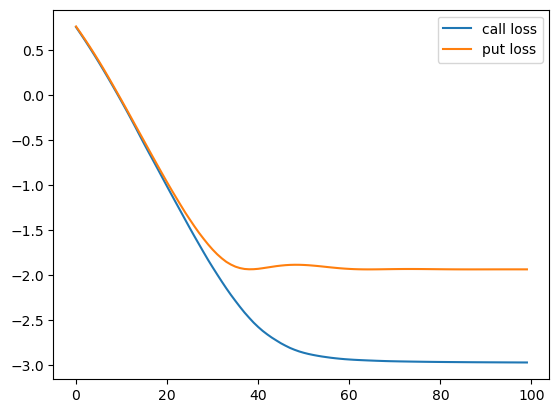

In [11]:
# plotting losses
c_plt_loss = gp_models[day_str]['call_losses']
p_plt_loss = gp_models[day_str]['put_losses']

plt.plot(range(len(c_plt_loss)), c_plt_loss, label='call loss')
plt.plot(range(len(p_plt_loss)), p_plt_loss, label='put loss')
plt.legend()
plt.show()

array([[1, 2],
       [1, 2],
       [1, 2]])

plotting vol smile for a specific time to expiry

In [12]:
t_to_exp = 25

# getting training/test data
c_tr = gp_models[day_str]['call_train']
c_tr = c_tr.loc[c_tr['T']==t_to_exp]
c_tst = gp_models[day_str]['call_test']
c_tst = c_tst.loc[c_tst['T']==t_to_exp]

p_tr = gp_models[day_str]['put_train']
p_tr = p_tr.loc[p_tr['T']==t_to_exp]
p_tst = gp_models[day_str]['put_test']
p_tst = p_tst.loc[p_tst['T']==t_to_exp]

# getting model/likelihood
c_plt_model = torch.load('models/call_GP_'+day_str+'.pt')
c_plt_model.eval()
p_plt_model = torch.load('models/put_GP_'+day_str+'.pt')
p_plt_model.eval()
c_ll = gp_models[day_str]['call_likelihood']
c_ll.eval()
p_ll = gp_models[day_str]['put_likelihood']
p_ll.eval()

# sample data
rng_mny = np.array(np.linspace(0.7, 1.3, 100)).astype(np.float32)
samp_mny = (rng_mny - 0.7) / (1.3 - 0.7)
t_arr = np.array([t_to_exp]*100).astype(np.float32)
samp_t = (t_arr - 20) / (365 - 20)

sample = torch.tensor([samp_t, samp_mny]).T #.reshape((1000, 2))

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    c_plt = c_ll(c_plt_model(sample))
    p_plt = p_ll(p_plt_model(sample))
    
# make dumas vol surface as well
c_dumas_model = dumas_surface(c_tr.copy(deep=True))
p_dumas_model = dumas_surface(p_tr.copy(deep=True))

c_dumas_preds = c_dumas_model.predict(np.array([rng_mny, rng_mny**2, t_arr, t_arr**2, rng_mny*t_arr]).T)
p_dumas_preds = p_dumas_model.predict(np.array([rng_mny, rng_mny**2, t_arr, t_arr**2, rng_mny*t_arr]).T)

c_dumas = pd.DataFrame({'mny':rng_mny, 'T':t_arr, 'iv':c_dumas_preds})
p_dumas = pd.DataFrame({'mny':rng_mny, 'T':t_arr, 'iv':p_dumas_preds})

/var/folders/df/9p_lmj2n2jq51ymf8kcw208w0000gn/T/ipykernel_44385/4257964050.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403251597/work/torch/csrc/utils/tensor_new.cpp:278.)
  sample = torch.tensor([samp_t, samp_mny]).T #.reshape((1000, 2))
/Users/adammoszczynski/miniforge3/envs/vol3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/adammoszczynski/miniforge3/envs/vol3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [13]:
len(c_tr)

65

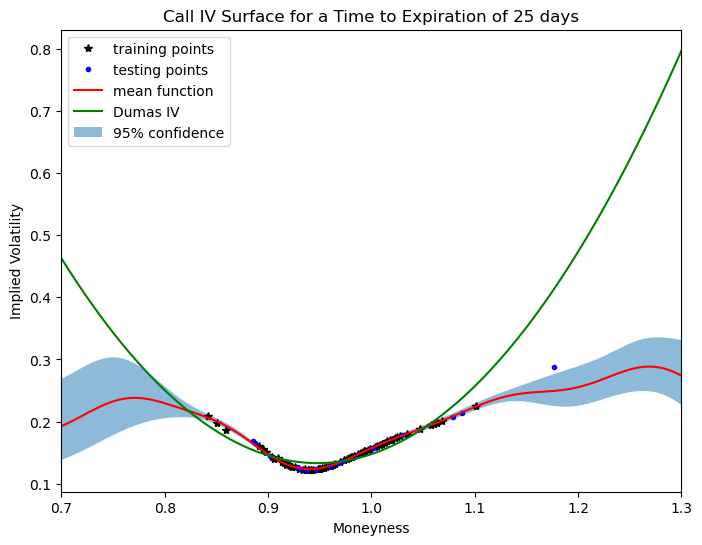

In [284]:
# calls
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = c_plt.confidence_region()
    
    # Plot training data as black stars
    ax.plot(c_tr['mny'], c_tr['iv'], 'k*', label='training points')
    
    # Plot testing data as blue dots
    ax.plot(c_tst['mny'], c_tst['iv'], 'b.', label='testing points')
    
    # undo exponentiation
    lower = math.e ** lower.numpy() #np.log(lower.numpy())
    upper = math.e ** upper.numpy() #np.log(upper.numpy() ) 
    preds = math.e ** c_plt.mean.numpy() #np.log(c_plt.mean.numpy())
    
    # undo x-axis scaling by using rng_mny
    ax.plot(rng_mny, preds, 'r', label='mean function')
    ax.plot(rng_mny, c_dumas_preds, 'g', label='Dumas IV')
    
    # Shade between the lower and upper confidence bounds
    ax.fill_between(rng_mny, lower, upper, alpha=0.5, label='95% confidence')
    
    ax.set_xlim([0.7, 1.3])
    ax.set_xlabel("Moneyness")
    ax.set_ylabel("Implied Volatility")
    ax.set_title(f"Call IV Surface for a Time to Expiration of {t_to_exp} days")
    ax.legend()


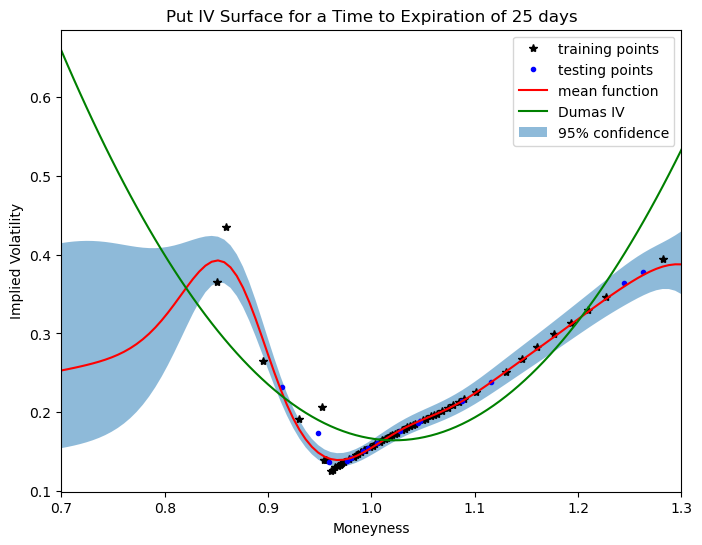

In [285]:
# puts
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = p_plt.confidence_region()
    
    # Plot training data as black stars
    ax.plot(p_tr['mny'], p_tr['iv'], 'k*', label='training points')
    
    # plot test data as blue stars
    ax.plot(p_tst['mny'], p_tst['iv'], 'b.', label='testing points')
    
    # undo exponentiation
    lower = math.e ** lower.numpy() #np.log(lower.numpy())
    upper = math.e ** upper.numpy() #np.log(upper.numpy() ) 
    preds = math.e ** p_plt.mean.numpy() #np.log(p_plt.mean.numpy())
    
    # undo x-axis scaling by using original range
    ax.plot(rng_mny, preds, 'r', label='mean function')
    ax.plot(rng_mny, p_dumas_preds, 'g', label='Dumas IV')

    
    # Shade between the lower and upper confidence bounds
    ax.fill_between(rng_mny, lower, upper, alpha=0.5, label='95% confidence')
    
    ax.set_xlim([0.7, 1.3])
    ax.set_xlabel("Moneyness")
    ax.set_ylabel("Implied Volatility")
    ax.set_title(f"Put IV Surface for a Time to Expiration of {t_to_exp} days")

    ax.legend()


Getting RMSE

In [257]:
print(f'call rmse for {day_str}: {gp_models[day_str]["call_RMSE"]}')
print(f'put rmse for {day_str}: {gp_models[day_str]["put_RMSE"]}')

call rmse for 2023-10-02: 0.003440957283601165
put rmse for 2023-10-02: 0.009609135799109936


In [258]:
c_rmse_arr = []
p_rmse_arr = []
for day in list(daily_chains.keys())[:2]:
    c_rmse_arr.append(gp_models[day]["call_RMSE"])
    p_rmse_arr.append(gp_models[day]["put_RMSE"])
    
print(f'mean call rmse: {np.array(c_rmse_arr).mean()}')
print(f'max call rmse: {np.array(c_rmse_arr).max()}')
print(f'min call rmse: {np.array(c_rmse_arr).min()}')
print()
print(f'mean put rmse: {np.array(p_rmse_arr).mean()}')
print(f'max put rmse: {np.array(p_rmse_arr).max()}')
print(f'min put rmse: {np.array(p_rmse_arr).min()}')


mean call rmse: 0.0025224750861525536
max call rmse: 0.003440957283601165
min call rmse: 0.001603993121534586

mean put rmse: 0.008325077593326569
max put rmse: 0.009609135799109936
min put rmse: 0.007041018921881914


Volatility Surface

In [259]:
c_surface = [] # coord (T, mny, iv)
p_surface = []

valid_t = daily_chains[day_str]['calls']['T'].unique()

# getting model/likelihood
c_plt_model = torch.load('models/call_GP_'+day_str+'.pt')
c_plt_model.eval()
p_plt_model = torch.load('models/put_GP_'+day_str+'.pt')
p_plt_model.eval()
c_ll = gp_models[day_str]['call_likelihood']
c_ll.eval()
p_ll = gp_models[day_str]['put_likelihood']
p_ll.eval()

rng_mny = np.array(np.linspace(0.7, 1.3, 100)).astype(np.float32)
samp_mny = (rng_mny - 0.7) / (1.3 - 0.7)

for t_to_exp in valid_t:

    # getting training/test data
    c_tr = gp_models[day_str]['call_train']
    c_tr = c_tr.loc[c_tr['T']==t_to_exp]
    c_tst = gp_models[day_str]['call_test']
    c_tst = c_tst.loc[c_tst['T']==t_to_exp]

    p_tr = gp_models[day_str]['put_train']
    p_tr = p_tr.loc[p_tr['T']==t_to_exp]
    p_tst = gp_models[day_str]['put_test']
    p_tst = p_tst.loc[p_tst['T']==t_to_exp]

    # sample data
    t_arr = np.array([t_to_exp]*100).astype(np.float32)
    samp_t = (t_arr - 20) / (365 - 20)

    sample = torch.tensor([samp_t, samp_mny]).T #.reshape((1000, 2))

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        c_plt = c_ll(c_plt_model(sample))
        p_plt = p_ll(p_plt_model(sample))
    
    # iv
    c_func = math.e ** c_plt.mean.numpy()
    p_func = math.e ** p_plt.mean.numpy()
    
    for i in range(100):
        c_surface.append([rng_mny[i], t_arr[i], c_func[i]])
        p_surface.append([rng_mny[i], t_arr[i], p_func[i]])
        
c_surface = np.array(c_surface)
p_surface = np.array(p_surface)

    

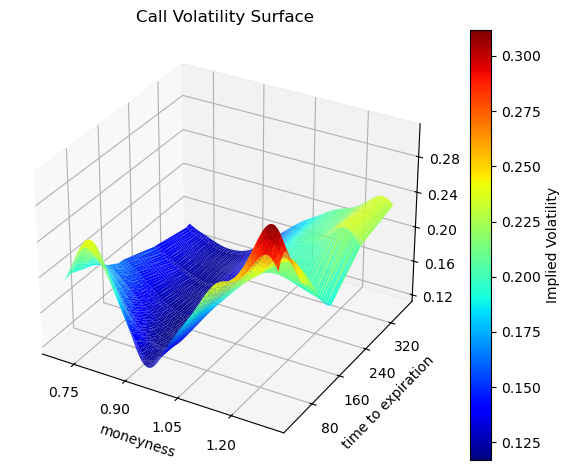

In [260]:
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

Xs = c_surface[:,0]
Ys = c_surface[:,1]
Zs = c_surface[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=cm.jet, linewidth=0)
fig.colorbar(surf, label='Implied Volatility')

ax.set_xlabel('moneyness')
ax.set_ylabel('time to expiration')

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_title('Call Volatility Surface')

fig.tight_layout()

plt.show() # or:

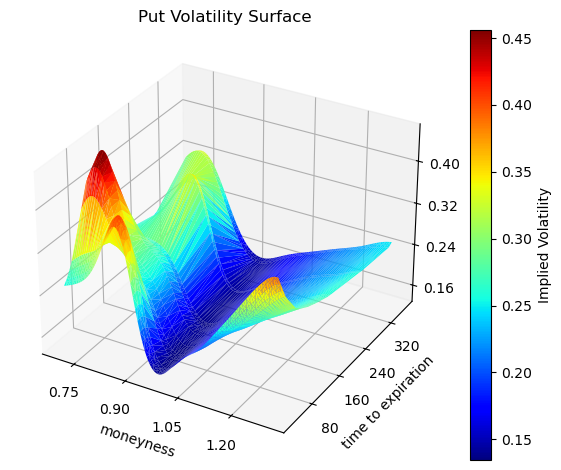

In [261]:
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

Xs = p_surface[:,0]
Ys = p_surface[:,1]
Zs = p_surface[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=cm.jet, linewidth=0)
fig.colorbar(surf, label='Implied Volatility')

ax.set_xlabel('moneyness')
ax.set_ylabel('time to expiration')

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_title('Put Volatility Surface')


fig.tight_layout()

plt.show() # or: